In [320]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
#import helper functions

torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(128)
torch.cuda.is_available()

False

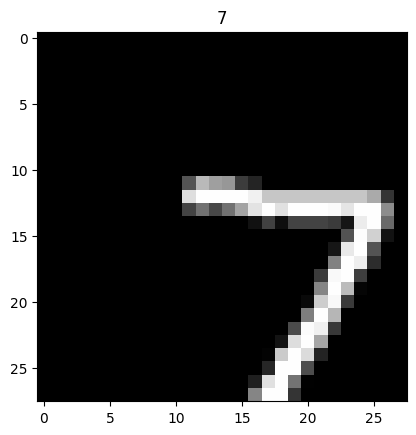

In [551]:
#Visualising data
# Download the dataset first
train_data = datasets.MNIST("~/data", train=True, download=True)
test_data = datasets.MNIST("~/data", train=False, download=True)

# custom_transform = transforms.Compose([ToTensor(),transforms.RandomResizedCrop(size=28, scale=(0.5, 1.0), ratio=(1.0, 1.0))]) 
#*Only rotates and change position which is better since we can't change brush size
custom_transform = transforms.Compose([ToTensor(),transforms.RandomAffine(degrees=10, translate=(0.2,0.2))])

train_loader = DataLoader(
        datasets.MNIST("./data", train=True, download=True, transform=custom_transform),
        batch_size=64,
        shuffle=True)
test_loader = DataLoader(
        datasets.MNIST("./data", train=False, download=True, transform=custom_transform),
        batch_size=64,
        shuffle=False)
images, labels = next(iter(test_loader))
img, label = images[0], labels[0]
plt.title(label.item())
plt.imshow(img.squeeze(), cmap="gray")

In [553]:
#! Unable to 
#Familier model, best 98.69% epoch 6
#nn.CrossEntropyLoss(),
#optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=0.001),

class digit_classifier(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier, self).__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2)#14/2
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
         nn.MaxPool2d(kernel_size=2, stride=2)#14/2

       
    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, len(train_data.classes))
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    #! Don't use softmax, stabilty reason? 
    return x
model_0 = digit_classifier(20).to(device) #Only one input channel

In [555]:
import help
import importlib
importlib.reload(help)
from help import train_step
from help import test_step
epochs = 6

for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n--------")
  train_step(model_0, train_loader,
           nn.CrossEntropyLoss(),
           optim.SGD(params=model_0.parameters(), lr=0.001, momentum=0.9),
           device)

  test_step(model_0, test_loader,
           nn.CrossEntropyLoss(),
           device)
        

Epoch 1
--------
train: 0.25247231125831604, 92.42070895522389%
test: 0.2149958312511444, 93.66042993630573%
Epoch 2
--------
train: 0.22901292145252228, 93.06869669509595%
test: 0.19528084993362427, 93.9390923566879%
Epoch 3
--------
train: 0.21270841360092163, 93.66671108742004%
test: 0.20268121361732483, 93.66042993630573%
Epoch 4
--------
train: 0.19159629940986633, 94.21308635394456%
test: 0.15924739837646484, 95.14331210191082%
Epoch 5
--------
train: 0.18180404603481293, 94.53957889125799%
test: 0.1604684740304947, 94.94426751592357%
Epoch 6
--------
train: 0.17167842388153076, 94.81776385927505%
test: 0.15461677312850952, 94.95421974522293%


{'0 - zero': -15.707125, '1 - one': -16.246313, '2 - two': -9.289588, '3 - three': -6.4267225, '4 - four': -11.709272, '5 - five': -9.475264, '6 - six': -19.939882, '7 - seven': -0.0020049962, '8 - eight': -13.883007, '9 - nine': -8.483907}


Text(0.5, 1.0, 'True: 7 - seven \n Prediction: 7 - seven')

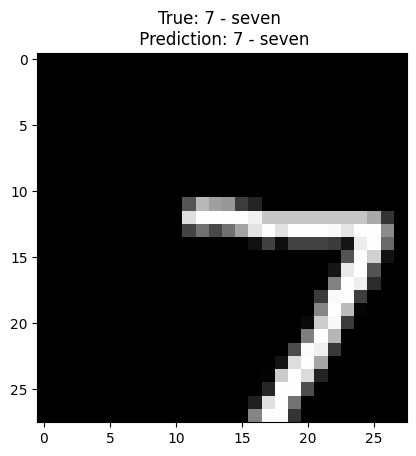

In [557]:
#Making some predictions
model_0.to(device="cpu")
model_0.eval()
with torch.inference_mode():
    y_logit = model_0(img.unsqueeze(1))
    # Get prediction probability (logit -> prediction probability)
    pred_prob = nn.LogSoftmax(dim=1)

    #print(pred_prob(y_logit/5).squeeze().numpy())
    #print(class_names)
    print(dict(zip(train_data.classes, pred_prob(y_logit).squeeze().numpy()))) #? Why /5

    # Get pred_prob off GPU for further calculations
    y_pred = y_logit.argmax(dim=1)
model_0.to(device=device)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f'True: {train_data.classes[label]} \n Prediction: {train_data.classes[y_pred]}')

In [556]:
x = torch.zeros(1,1,28,28)
model_0.eval()

torch.onnx.export(model_0,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model_3.onnx",   # where to save the model (can be a file or file-like object)
                  opset_version=9,          # the ONNX version to export the model to
                  verbose=True,        # store the trained parameter weights inside the model file
                  )


x.shape

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



torch.Size([1, 1, 28, 28])